<a href="https://colab.research.google.com/github/DIFACQUIM/Cursos/blob/main/08_similitud_representaciones_moleculares_fps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Huellas digitales moleculares (molecular fingerprints)**


---



---



Script realizado por Raziel Cedillo-González.
Última actualización: 17-10-2023.
Contacto: brayanraziel1997@gmail.com


---



---






# ***Tabla de Contenido***
- [0 - ***Librerias: cargado e instalación***](#0)
- [1 - ***Introducción***](#1)
- [2 - ***Huellas moleculares basadas en subestructuras***](#2)
  - [2.1 - **Key MACCS**](#2.1)
    - [2.1.1 - *Visualización gráfica de la huella molecular*](#2.1.1)

  - [2.2 - **PubChem**](#2.2)
  - [2.3 - **BCI (Bristol Chemoinformatics Library Fingerprint)**](#2.2)

- [3 - ***Huellas topológicas o basadas en rutas***](#3)
- [4 - ***Huellas circulares***](#4)
  - [4.1 - **Conectividad extendida (ECFP4, ECFP6)**](#4.1)
  - [4.2 - **De clase funcional (FCFP)**](#4.2)
- [5 - ***Ejercicio con base de datos***](#5)
- [6 - ***Referencias y fuentes de consulta***](#6)



---



---




<a name='0'></a>

# **Librerias: cargado e instalación**

In [ ]:
import time
from IPython.utils import io
import tqdm.notebook
import os, sys, random
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
        pbar.update(30)

        !pip install rdkit
        !pip install PubChemPy
        !pip install Pillow

        pbar.update(30)
        import pandas as pd
        from rdkit import Chem, DataStructs, RDConfig
        from rdkit.Chem import MACCSkeys, AllChem, RDKFingerprint, Draw, Descriptors, PandasTools, Pharm2D
        from rdkit.Chem.Pharm2D import Gobbi_Pharm2D, Generate
        import pubchempy as pcp
        import matplotlib.pyplot as plt
        import numpy as np
        pbar.update(40)

  0%|          | 0/100 [00:00<?, ?it/s]

<a name='1'></a>

# **1 - Introducción**
Las huellas digitales moleculares (molecular fingerprints) son un tipo de descriptor molecular que codifica la estructura de una molécula en una secuencia de bits de manera que se pueda comparar y analizar computacionalmente.

La mayoría de los métodos usan solamente grafos moleculares en 2D y son llamados huellas digitales 2D; sin embargo, algunos métodos son capaces de almacenar información en 3D, más notablemente las huellas moleculares farmacofóricas.
Existen varios tipos de huellas digitales, incluyendo huellas digitales basadas en subestructuras, como las "claves MACCS" (key MACCS), y huellas digitales topológicas, que codifican la topología general o la conectividad de la molécula sin codificar explícitamente subestructuras específicas.

En aspectos generales, las huellas digitales basadas en subestructuras se crean codificando la presencia o ausencia de subestructuras específicas en la molécula, mientras que las huellas digitales topológicas codifican la conectividad o forma general de la molécula. Las huellas digitales topológicas se pueden subdividir en huellas digitales basadas en rutas, que codifican la presencia o ausencia de rutas particulares en la representación gráfica de la molécula, y huellas digitales circulares, que codifican la presencia o ausencia de subestructuras circulares o patrones particulares.

Las huellas digitales se utilizan típicamente para calcular la similitud entre dos moléculas, lo que se puede utilizar para identificar moléculas que son estructuralmente similares y que pueden tener una actividad biológica similar, lo que las convierte en posibles candidatos a fármacos. Las puntuaciones de similitud se calculan típicamente comparando las huellas digitales de dos moléculas y calculando una puntuación de similitud.

El uso de huellas digitales moleculares en quimioinformática tiene muchas ventajas, incluyendo la capacidad de representar estructuras moleculares complejas de manera eficiente computacionalmente y la capacidad de comparar grandes bases de datos de moléculas de manera rápida y precisa. Sin embargo, también hay limitaciones en el uso de huellas digitales, como la incapacidad de capturar todos los aspectos de la similitud molecular y el potencial de falsos positivos o falsos negativos en los cálculos de similitud.

En general, las huellas digitales moleculares son una herramienta poderosa en quimioinformática que se utilizan ampliamente en el descubrimiento de fármacos, ciencias de materiales y otras áreas de investigación. La elección del tipo de huella digital dependerá de la aplicación específica y las propiedades de las moléculas que se estén analizando.

Nota: La generación de los diversos fingerprints de este script consideran el SMILES de la aspirina como input para fines prácticos.

In [ ]:
aspirin_smiles='CC(C)(C)NCC(C1=CC(=C(C=C1)O)CO)O'
mol = Chem.MolFromSmiles(aspirin_smiles)
img = Draw.MolToImage(mol) # Genera una imagen de la molécula
img.show() # Muestra la imagen
img.save("mol_image.png")

<a name='2'></a>

# **2 - Huellas moleculares basadas en subestructuras**


Las firmas basadas en subestructuras se generan mediante la codificación de la presencia o ausencia de una carácteristica o subestructuras específicas en una molécula de una lista dada de claves estructurales. Esto implica definir un conjunto de subestructuras o fragmentos moleculares que se consideran importantes o relevantes para una aplicación específica y, luego, generar una firma binaria que codifique si cada una de estas subestructuras está presente o ausente en la molécula. Algunas de las huellas basadas en subestructuras más comunes son:

<a name='2.1'></a>

## **2.1 - MACCS Keys**
 Viene en dos variantes de fierente longitud de bits, una con 960 y otra con 166 claves estructurales basadas en patrones SMARTS. La más corta es la más comúnmente usada debido a su longitud relativamente corta pero cubre la mayor parte de las características químicas de interés para el descubrimiento de fármacos y cribado virtual. Además, diversos softwares son capaces de calcularlos, lo cual no es cierto para la versión larga.
A continuación, un ejemplo de código en el cual se establece el uso de MACCS keys

In [ ]:
# Definir las moléculas
ms = [Chem.MolFromSmiles(aspirin_smiles),
      Chem.MolFromSmiles('CCO'),
      Chem.MolFromSmiles('COC')]
# Generar las MACCS Keys para cada molécula
fps = [MACCSkeys.GenMACCSKeys(x) for x in ms]

# Convertir las MACCS Keys en una representación legible
for i, fp in enumerate(fps):
    fps_bits=list(fp.GetOnBits())
    print(f"Molécula {i+1}:")
    print(f"Key MACCS: {fp.ToBitString()}")
    print(f"Lista de bits activos: {fps_bits}")

Molécula 1:
Key MACCS: 00000000000000000000000000000000000000000000000000000110000000000010000000100000001000000110000100001000100001001100100000000001000110000011010110100111110111111111110
Lista de bits activos: [53, 54, 66, 74, 82, 89, 90, 95, 100, 104, 109, 112, 113, 116, 127, 131, 132, 138, 139, 141, 143, 144, 146, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165]
Molécula 2:
Key MACCS: 00000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000001000010000000000000000000000001000000000000010101001000100
Lista de bits activos: [82, 109, 114, 139, 153, 155, 157, 160, 164]
Molécula 3:
Key MACCS: 00000000000000000000000000000000000000000000000000000000000000000000000000100000000000100000010000000000000000000000000000000010000000000000000000000100000001001000100
Lista de bits activos: [74, 86, 93, 126, 149, 157, 160, 164]


<a name='2.1.1'></a>

### 2.1.1 - Visualización gráfica de la huella mecular
#### Gráfico de barras o histograma

In [ ]:
def visualización_fps_completa(fps):
  bit_counts = [fps.GetBit(id) for id in range(fps.GetNumBits())]   # Contar la frecuencia de cada bit activo
  # Crear un histograma
  plt.figure(figsize=(9,4))
  plt.bar(range(len(bit_counts)), bit_counts)
  plt.xlabel("Índice del bit")
  plt.ylabel("Frecuencia")
  plt.title("Histograma de la Huella molecular")
  plt.tight_layout()
  plt.show()

In [ ]:
def visualización_fps_activos(fps):
  for fp, i in enumerate(fps):
    bit_counts = [i.GetBit(id) for id in range(i.GetNumBits())]     # Contar la frecuencia de cada bit activo
    # Obtener los índices de los bits activos (distintos de cero)
    active_indices = [i for i, bit in enumerate(bit_counts) if bit != 0]
    # Crear una lista de etiquetas para el eje x con los índices activos
    x_labels = [str(i) for i in active_indices]

    # Crear un histograma
    plt.figure(figsize=(15, 4))
    plt.bar(active_indices, [bit_counts[i] for i in active_indices])
    plt.xlabel("Índice del bit")
    plt.ylabel("Frecuencia")
    plt.title("Histograma de la Huella molecular de la "+f"Molécula {fp+1}:")
    plt.yticks(np.arange(0, 1.1, step=1.0))
    plt.xticks(active_indices, x_labels, rotation=90)  # Establecer las etiquetas del eje x
    plt.tight_layout()
    plt.show()

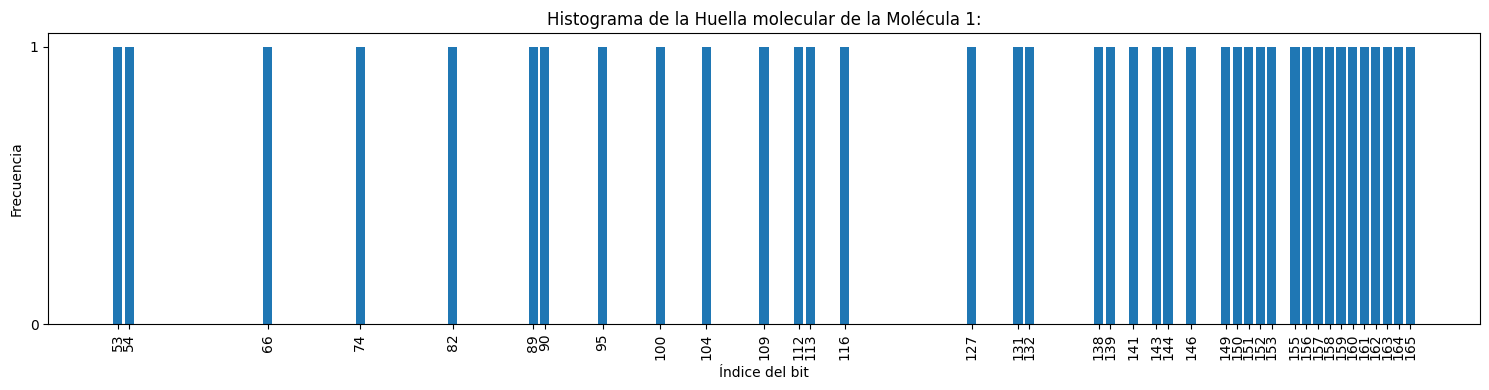

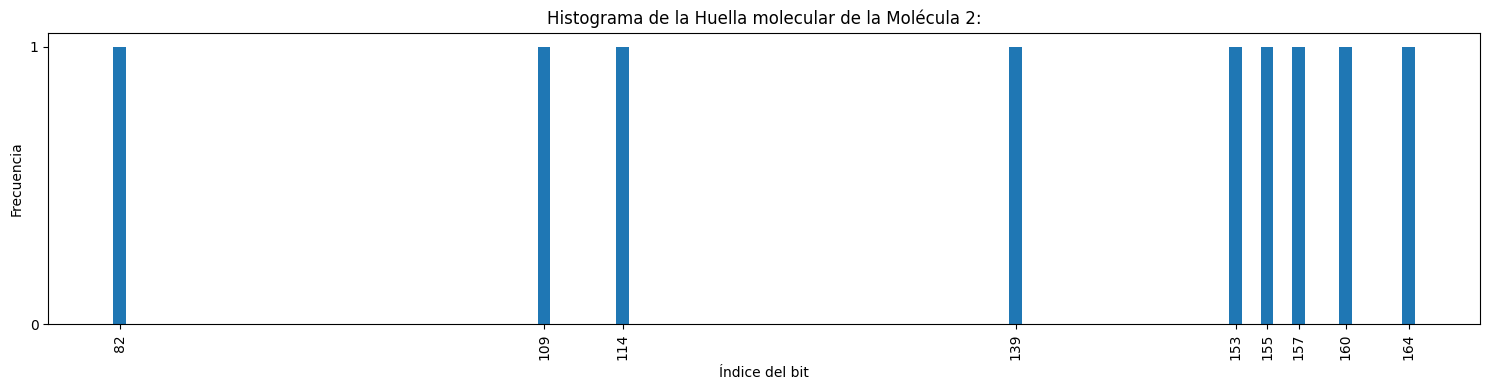

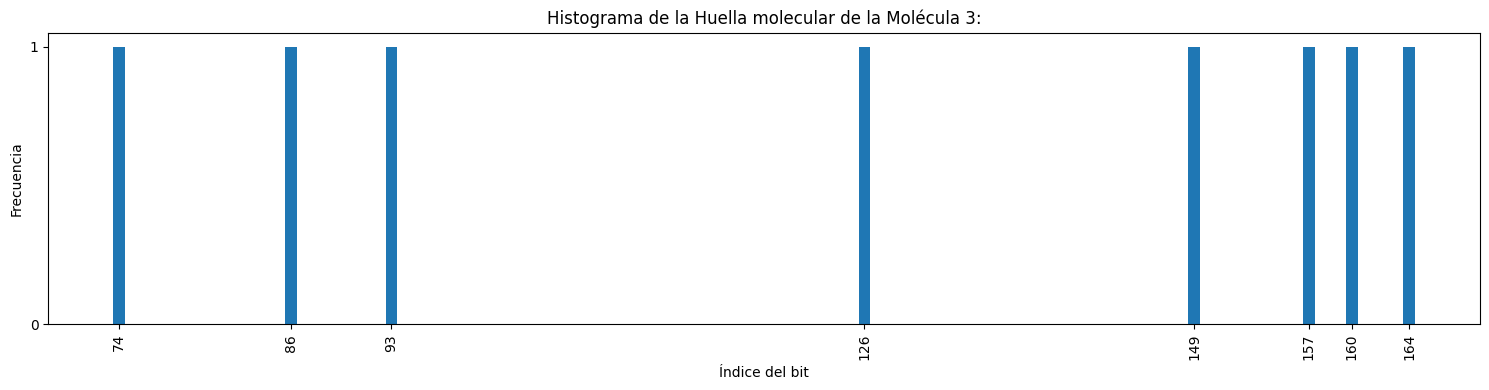

In [ ]:
visualización_fps_activos(fps=fps)

<a name='2.2'></a>

## **2.2 - PubChem**
Cuenta con 881 claves estructurales. Son empleados por PubChem para la búsqueda por similitud y por vecinos. Está implementado en ChemFP y en CDK.
A continuación, un ejemplo de código en el cual se establece el uso de las huellas moleculares de PubChem.

In [ ]:
# Nombre o identificador del compuesto que deseas buscar
compound_name = "aspirin"

# Realiza la búsqueda en PubChem
compounds = pcp.get_compounds(compound_name, 'name')
if compounds:
    # Obtiene el primer resultado (puede haber múltiples resultados)
    compound = compounds[0]
    # Obtiene la huella molecular de PubChem
    fingerprint = compound.fingerprint
    posiciones_no_cero = {}
    # Enumerar el string y agregar las posiciones con valores no cero a un diccionario
    for i, valor in enumerate(fingerprint):
        if valor != '0':
            posiciones_no_cero[i] = valor

    print(f"Nombre del compuesto: {compound.synonyms[0]}")
    print(f"Lista de bits activos (posición:valor)= {posiciones_no_cero}")
    print(f"Huella molecular PubChem: {fingerprint}")

else:
    print(f"No se encontraron resultados para '{compound_name}'.")

Nombre del compuesto: aspirin
Lista de bits activos (posición:valor)= {5: '3', 6: '7', 7: '1', 8: 'C', 10: '7', 12: '3', 13: '8', 52: '3', 71: '1', 78: '1', 79: 'A', 85: '8', 91: 'C', 93: '4', 94: '8', 96: '9', 97: '8', 100: '3', 101: '2', 103: 'E', 104: '8', 109: '6', 112: '8', 113: '8', 115: '2', 116: '2', 118: 'D', 119: '2', 121: '8', 125: '2', 127: '8', 130: '2', 131: '4', 132: '2', 137: '8', 138: '8', 139: '8', 141: '1', 143: '6', 145: '8', 146: 'C', 147: '8', 149: 'C', 150: '2', 151: '7', 152: '3', 153: '6', 154: '8', 155: '4', 156: '3', 157: '5', 158: '1', 159: 'A', 160: '8', 161: '2', 162: '7', 163: 'B', 164: '6', 166: 'A', 167: '5', 168: 'E', 170: '1', 171: '1', 173: '8', 174: 'B', 175: '9', 176: '8', 177: '7', 178: '8', 179: '8', 180: 'C', 181: '8', 182: '2', 184: '8', 185: 'E', 197: '8', 212: '1'}
Huella molecular PubChem: 00000371C0703800000000000000000000000000000000000000300000000000000000010000001A00000800000C04809800320E80000600880220D208000208002420000888010608C80C2736

<a name='2.3'></a>

## **2.3 - BCI (Bristol Chemoinformatics Library Fingerprint)**
Pueden ser generados usando diferentes números de bits y puede ser modificado por el usuario de diversas maneras pero el diccionario estándar de subestructuras incluye 1052 claves. Solo está disponible en el kit de herramientas de BCI.
A continuación, un ejemplo de código en el cual se establece el uso de las huellas moleculares de BCI.

<a name='3'></a>

# **3 - Huellas moleculares topológicas o basadas en rutas**
Las firmas topológicas se generan mediante la codificación de la conectividad o forma general de una molécula, sin codificar explícitamente subestructuras específicas. Trabajan al analizar todos los fragmentos de la molécula siguiendo un camino (usualmente lineal) hasta un cierto número de enlaces, y después combinar cada una de estas rutas (secuencias de átomos o enlaces) para crear la huella molecular. Lo anterior significa que cualquier molécula puede producir una huella molecular significativa y su longitud puede ser ajustada. Son usados comúnmente para una veloz búsqueda y filtrado por subestructuras. Se debe tomar en cuenta que un solo bit no se puede rastrear hasta una característica determinada y un bit determinado puede estar configurado por más de una característica diferente (colisión de bits). La mayoría de los softwares implementan estas huellas moleculares o basadas en ellas. Daylight es el ejemplo más común de este tipo de huellas moleculares.
A continuación, un ejemplo de código en el cual se establece el uso de las huellas moleculares topológicas.

In [ ]:
# Crear una molécula a partir de un SMILES
smiles = aspirin_smiles
mol = Chem.MolFromSmiles(smiles)

if mol is not None:
    # Generar la huella molecular topológica (Morgan fingerprint)
    radius = 2  # Radio de búsqueda ajustable
    topological_fp =  AllChem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol)

    # Convertir la huella molecular en una lista de bits activos
    topological_fp_bits = list(topological_fp.GetOnBits())

    print(f"Lista de bits activos: {topological_fp_bits}")
    print(f"Huella topológica:{topological_fp.ToBitString()}")
else:
    print("No se pudo crear una molécula a partir del SMILES proporcionado.")

Lista de bits activos: [0, 376, 380, 512, 552, 592, 596, 652, 740, 741, 772, 936, 1312, 1532, 1548, 1549, 1564, 1712, 1788, 1804, 1844, 1845, 1868, 1892]
Huella topológica:100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000100000000000000000000000000000000000000010001000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000001100000000000000000000000000000010000000000000000000000000000000000000000000000000000000

<a name='4'></a>

# **4 - Huellas moleculares circulares**
Las firmas circulares también pertenecen al tipo topológico, sin embargo son un tanto diferentes ya que estas no se centran en la búsqueda de rutas, sino en el ambiente de cada átomo hasta un determinado radio. No son adecuados para búsquedas por subestructura pero si para búsquedas de similitud estructural completa.

<a name='4.1'></a>

## **4.1 - Conectividad extendida (ECFP, Extended-Connectivity Fingerprints)**
La huella molecular circular basada en el algoritmo de Morgan es la estándar, la cual fue diseñada específicamente para su uso en modelado estructura-actividad. Representan el vecindario atómico circular y produce una huella molecular de longitud variable. Son usadas comúnmente considerando un diámetro de 4 Å (ECFP4) y 6 Å (ECFP6). Notables softwares proporcionan estas huellas moleculares, tales como: Pipeline Pilot, Chemaxon’s JChem, CDK y RDKit.
A continuación, un ejemplo de código en el cual se establece el uso de las huellas moleculares circulares.

In [ ]:
# Crear una molécula a partir de un SMILES
smiles = aspirin_smiles
mol = Chem.MolFromSmiles(smiles)

if mol is not None:
    # Generar la huella molecular ECFP4 (con radio 2)
    ecfp4_fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    # Generar la huella molecular ECFP6 (con radio 3)
    ecfp6_fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048)

    # Convertir las huellas digitales en representaciones legibles
    ecfp4_fingerprint_bits = list(ecfp4_fingerprint.GetOnBits())
    ecfp6_fingerprint_bits = list(ecfp6_fingerprint.GetOnBits())


    print(f"Lista de bits activos en ECFP4: {ecfp4_fingerprint_bits}")
    print(f"Huella molecular ECFP4: {ecfp4_fingerprint.ToBitString()}")
    print(f"Lista de bits activos en ECFP6: {ecfp6_fingerprint_bits}")
    print(f"Huella molecular ECFP6: {ecfp6_fingerprint.ToBitString()}")
else:
    print("No se pudo crear una molécula a partir del SMILES proporcionado.")


Lista de bits activos en ECFP4: [1, 80, 89, 114, 222, 227, 269, 392, 548, 603, 606, 632, 705, 807, 837, 843, 875, 1057, 1152, 1349, 1362, 1365, 1380, 1434, 1475, 1537, 1573, 1578, 1602, 1607, 1750, 1853, 1873]
Huella molecular ECFP4: 0100000000000000000000000000000000000000000000000000000000000000000000000000000010000000010000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000010000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000001001000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000

<a name='4.2'></a>

## **4.2 - De clase funcional (FCFP, Functional-Class Fingerprints)**

Son una variante de los ECFP, solo que más abstractos y que en lugar de indexar un átomo particular en el ambiente, indexan el rol del átomo. Así que diferentes átomos o grupos con la misma o similar función no son distinguibles por la huella molecular. Lo anterior les permite ser usado como huellas moleculares farmacofóricas. La mayoría de los softwares que soportan ECFP también soportan esta variante.

In [ ]:
# Crear una molécula a partir de un SMILES
smiles = aspirin_smiles
mol = Chem.MolFromSmiles(smiles)

if mol is not None:
    # Configurar parámetros para la huella digital FCFP
    radius = 2  # Radio ajustable
    use_features = True  # Indexación del rol del átomo
    # Generar la huella digital FCFP
    fcfp_fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, useFeatures=use_features, nBits=2048)
    # Convertir la huella digital en una representación legible
    fcfp_fingerprint_bits = list(fcfp_fingerprint.GetOnBits())

    print(f"Lista de bits activos en FCFP: {fcfp_fingerprint_bits}")
    print(f"Huella molecular FCFP: {fcfp_fingerprint.ToBitString()}")
else:
    print("No se pudo crear una molécula a partir del SMILES proporcionado.")


Lista de bits activos en FCFP: [0, 3, 4, 19, 149, 199, 428, 478, 585, 772, 808, 821, 869, 875, 1011, 1014, 1085, 1099, 1161, 1394, 1434, 1556, 1925, 1971, 2017, 2041]
Huella molecular FCFP: 100110000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000010

<a name='5'></a>
# ***5. Ejercicio con base de datos***

In [ ]:
#Leer archivo
url_smiles = "https://raw.githubusercontent.com/DIFACQUIM/Cursos/main/Datasets/Fingerprints.csv"
df = pd.read_csv(url_smiles)
df.head()

,ID,smiles,IC50,std_units,pIC50,%activity(100uM),Activity
0,CHEMBL3087498,Brc1c2c(N)ncnc2n([C@]2[C@](O)[C@](O)[C@@](CN(C...,0.3,nM,9.522879,NaN,Inhibitor
1,CHEMBL2171169,O=C(NCCCN(C(C)C)C[C@@]1[C@@](O)[C@@](O)[C@](n2...,2.9,nM,8.537602,NaN,Inhibitor
2,CHEMBL83747,Brc1c(O)ccc(C/C(=N\O)/C(=O)NCCSSCCNC(=O)/C(=N/...,18.6,nM,7.730487,NaN,Inhibitor
3,CHEMBL4215326,O(C)c1c(OC2CC3(CN(C)C3)C2)cc2nc(-c3oc(C)cc3)cc...,21.0,nM,7.677781,NaN,Inhibitor
4,CHEMBL1201129,O=C1N([C@@]2O[C@](CO)[C@@](O)C2)C=NC(N)=N1,30.0,nM,7.522879,NaN,Inhibitor


,ID,smiles,IC50,std_units,pIC50,%activity(100uM),Activity,ROMol,ROMol_H
0,CHEMBL3087498,Brc1c2c(N)ncnc2n([C@]2[C@](O)[C@](O)[C@@](CN(C...,0.3,nM,9.522879,NaN,Inhibitor,,
1,CHEMBL2171169,O=C(NCCCN(C(C)C)C[C@@]1[C@@](O)[C@@](O)[C@](n2...,2.9,nM,8.537602,NaN,Inhibitor,,
2,CHEMBL83747,Brc1c(O)ccc(C/C(=N\O)/C(=O)NCCSSCCNC(=O)/C(=N/...,18.6,nM,7.730487,NaN,Inhibitor,,
3,CHEMBL4215326,O(C)c1c(OC2CC3(CN(C)C3)C2)cc2nc(-c3oc(C)cc3)cc...,21.0,nM,7.677781,NaN,Inhibitor,,
4,CHEMBL1201129,O=C1N([C@@]2O[C@](CO)[C@@](O)C2)C=NC(N)=N1,30.0,nM,7.522879,NaN,Inhibitor,,
...,...,...,...,...,...,...,...,...,...
194,F447-0397,S(=O)(=O)(Nc1cc2c(C(=O)O)cc(N3CCN(c4ccc(OC)cc4...,57000.0,nM,4.244125,NaN,Inhibitor,,
195,FC.CSC.04E fr 16-20,Clc1cc(NS(=O)(=O)c2ccc(NS(=O)(=O)c3cc4c(cc3)cc...,NaN,NaN,NaN,97.0,Inhibitor,,
196,FC.CSC.10C fr 4,S(=O)(=O)(Nc1cc(OC)cc(OC)c1)c1cc2c(cc1)cccc2,NaN,NaN,NaN,NaN,Inhibitor,,
197,DLP18,O=C(Nc1nocc1)CN1CCN(c2ccc(C(=O)OCC)cc2)CC1,NaN,NaN,NaN,NaN,Inhibitor,,

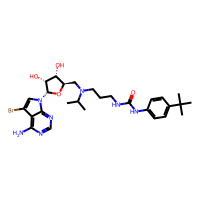
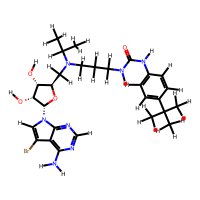
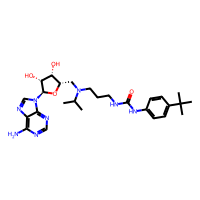
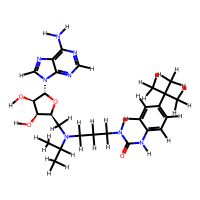
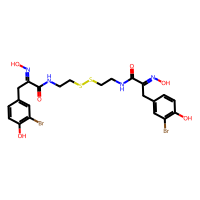
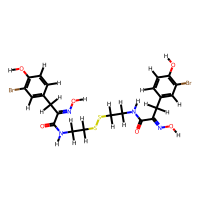
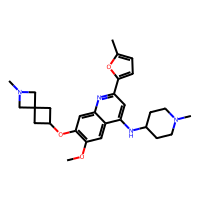
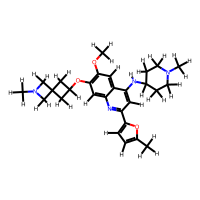
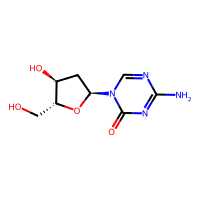
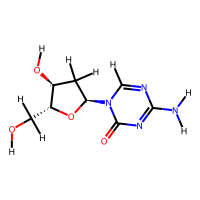
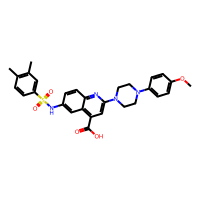
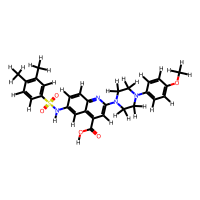
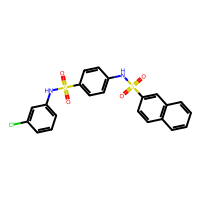
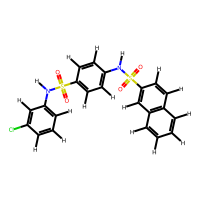
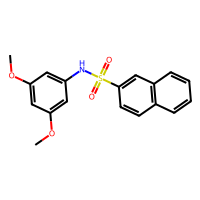
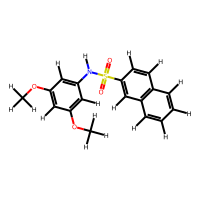
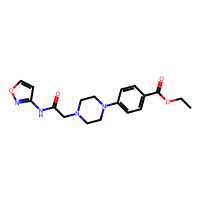
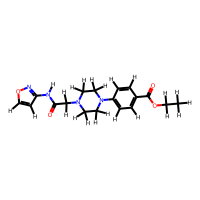
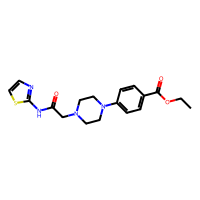
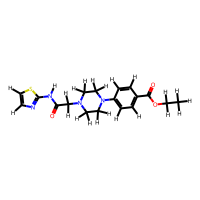

In [ ]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles')
df['ROMol_H'] = [Chem.AddHs(m) for m in df['ROMol']]
df

In [ ]:
def fingerprint(dataframe): #dataframe['column']
  factory = Gobbi_Pharm2D.factory
  for m in dataframe['ROMol_H']:
    #mol = Chem.MolFromSmiles(m)
    dataframe['ECFP6'] = AllChem.GetMorganFingerprintAsBitVect(m,radius=3, nBits=1024)
    dataframe['MACCS']= MACCSkeys.GenMACCSKeys(m)
    AllChem.EmbedMolecule(m) #
    matriz = Chem.Get3DDistanceMatrix(m)
    dataframe['Fp2D']=Chem.Pharm2D.Generate.Gen2DFingerprint(m,factory)
    dataframe['Fp3D']=Chem.Pharm2D.Generate.Gen2DFingerprint(m,factory, dMat = matriz)
  return dataframe

,ID,smiles,IC50,std_units,pIC50,%activity(100uM),Activity,ROMol,ROMol_H,ECFP6,MACCS,Fp2D,Fp3D
0,CHEMBL3087498,Brc1c2c(N)ncnc2n([C@]2[C@](O)[C@](O)[C@@](CN(C...,0.3,nM,9.522879,NaN,Inhibitor,,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL2171169,O=C(NCCCN(C(C)C)C[C@@]1[C@@](O)[C@@](O)[C@](n2...,2.9,nM,8.537602,NaN,Inhibitor,,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL83747,Brc1c(O)ccc(C/C(=N\O)/C(=O)NCCSSCCNC(=O)/C(=N/...,18.6,nM,7.730487,NaN,Inhibitor,,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL4215326,O(C)c1c(OC2CC3(CN(C)C3)C2)cc2nc(-c3oc(C)cc3)cc...,21.0,nM,7.677781,NaN,Inhibitor,,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL1201129,O=C1N([C@@]2O[C@](CO)[C@@](O)C2)C=NC(N)=N1,30.0,nM,7.522879,NaN,Inhibitor,,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,F447-0397,S(=O)(=O)(Nc1cc2c(C(=O)O)cc(N3CCN(c4ccc(OC)cc4...,57000.0,nM,4.244125,NaN,Inhibitor,,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
195,FC.CSC.04E fr 16-20,Clc1cc(NS(=O)(=O)c2ccc(NS(=O)(=O)c3cc4c(cc3)cc...,NaN,NaN,NaN,97.0,Inhibitor,,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
196,FC.CSC.10C fr 4,S(=O)(=O)(Nc1cc(OC)cc(OC)c1)c1cc2c(cc1)cccc2,NaN,NaN,NaN,NaN,Inhibitor,,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
197,DLP18,O=C(Nc1nocc1)CN1CCN(c2ccc(C(=O)OCC)cc2)CC1,NaN,NaN,NaN,NaN,Inhibitor,,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

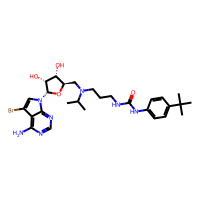
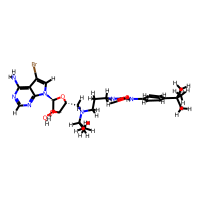
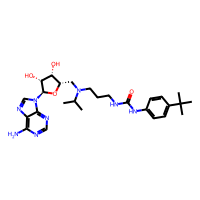
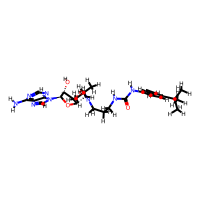
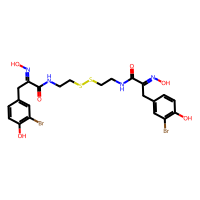
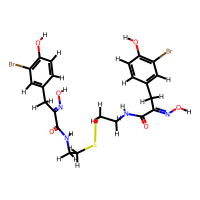
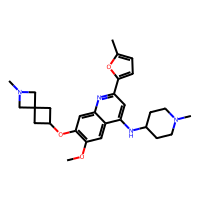
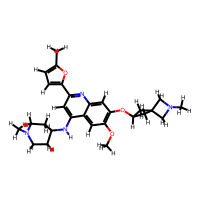
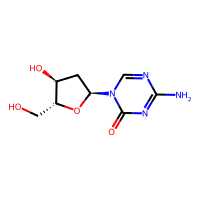
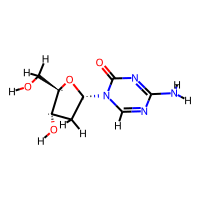
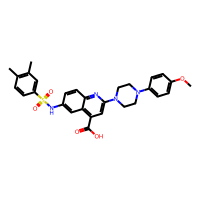
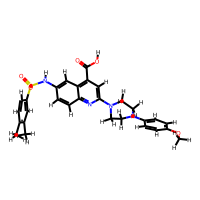
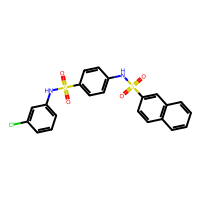
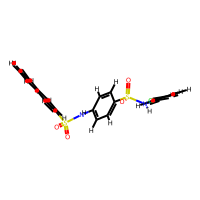
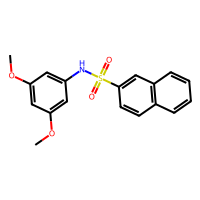
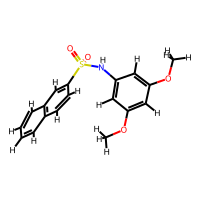
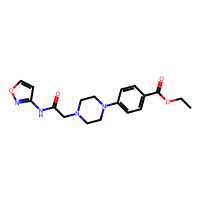
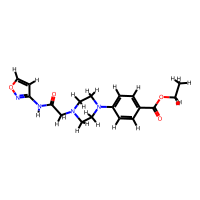
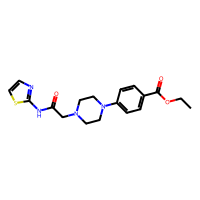
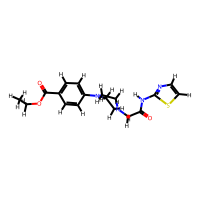

In [ ]:
fingerprint(dataframe=df)

<a name='6'></a>

# **6 - Referencias y fuentes de consulta**

* Gallegos Saliner A. 2006. “Mini-Review on Chemical Similarity and Prediction of Toxicity.” Current Computer-Aided Drug Design 2 (2): 105–22.
* Maggiora, Gerald, Martin Vogt, Dagmar Stumpfe, and Jürgen Bajorath. 2014. “Molecular Similarity in Medicinal Chemistry.” Journal of Medicinal Chemistry 57 (8): 3186–3204.
* Naveja, J. Jesús, Fernanda I. Saldívar-González, Norberto Sánchez-Cruz, and José L. Medina-Franco. 2019. “Cheminformatics Approaches to Study Drug Polypharmacology.” In Multi-Target Drug Design Using Chem-Bioinformatic Approaches, edited by Kunal Roy, 3–25. New York, NY: Springer New York.
* A.h.-L., and Y.g.s. 1992. “Concepts and Applications of Molecular Similarity.” Journal of Molecular Structure 269 (3-4): 376–77.
* Cereto-Massagué, Adrià, María José Ojeda, Cristina Valls, Miquel Mulero, Santiago Garcia-Vallvé, and Gerard Pujadas. 2015. “Molecular Fingerprint Similarity Search in Virtual Screening.” Methods 71 (January): 58–63.